### References:

Darmet, L., Ladouce, S., & Dehais, F. (2023). **Shortened calibration of code-VEP based BCI by improved deep learning 
architecture and golden subjects pre-training.** *In 11th International IEEE EMBS Conference on Neural Engineering.* 

Source: https://github.com/neuroergoISAE/offline_cVEP_bitwise

Thielen, J., Marsman, P., Farquhar, J., & Desain, P. (2021). **From full calibration to zero training for a code-modulated
visual evoked potentials for brain–computer interface**. *Journal of Neural Engineering, 18(5), 056007.*

Source: https://gitlab.socsci.ru.nl/jthielen/pynt/-/blob/main/examples

Sebastian Nagel

Source: https://github.com/thecodingdad/eeg2code

Teulings, D.E.J. David (2022).  **an-application-of-recurrency-to-eeg2code-deep-learning**

Source: https://gitlab.socsci.ru.nl/D.Teulings/an-application-of-recurrency-to-eeg2code-deep-learning/-/tree/master

In [1]:
# the path to the dataset
path = 'D:/Dataset'

In [2]:
import os
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import pynt
import keras
import sys
import scipy.io as sio
import tensorflow as tf
import time
import seaborn
import random
import keras.utils as ku
from scipy import stats
from scipy.stats import wilcoxon
from keras.optimizers import adam
from keras.callbacks import History 
from scipy.stats import mode
from sklearn.metrics import accuracy_score
from tensorflow.python.keras import backend
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras import initializers
from keras.models import load_model
from keras.models import Sequential
from keras.layers import (Input,
                          InputLayer,
                          GRU,
                          RNN,
                          LSTM,
                          Reshape,
                          SimpleRNN,
                          Conv1D,
                          Conv2D,
                          MaxPooling1D,
                          MaxPooling2D,
                          Permute,
                          Flatten, 
                          Dense,
                          BatchNormalization, 
                          Activation,
                          Dropout
                         )
from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_decomposition import CCA
from tensorflow.python.keras import backend
from tensorflow.keras.models import load_model

# Settings
### Hyperparameters, function that load data, and function that slicing data to epoch

In [3]:
subjects =  ['sub-01','sub-02','sub-03','sub-04','sub-05']
epoch_size = int(300 * 0.3)
step_size = 1
learning_rate = 0.001
batch_size = 256
epochs = 15
adam = keras.optimizers.RMSprop(learning_rate=learning_rate)
n_folds = 5

In [4]:
def load_data(subject):
    fn = os.path.join(path, 'derivatives300', 'offline', subject, f'{subject}_gdf.npz')
    tmp = np.load(fn)
    X = tmp['X']
    V = tmp['V']
    y = tmp['y']
    fs = tmp['fs']
    return X, V, y, fs

In [5]:
def trials_to_epochs(X, y, codes, epoch_size, step_size):
    n_trials, n_channels, n_samples = X.shape
    n_epochs = int((n_samples - epoch_size) / step_size)
    X_sliced = np.zeros((n_trials, n_epochs, n_channels, epoch_size), 
        dtype='float32')
    y_sliced = np.zeros((n_trials, n_epochs), dtype='uint8')
    for i_epoch in range(n_epochs):
        start = i_epoch * step_size
        X_sliced[:, i_epoch, :, :] = X[:, :, start:start+epoch_size]
        y_sliced[:, i_epoch] = codes[start % codes.shape[0], y]
    return X_sliced, y_sliced

# Method
### EEG2Code

In [6]:
"""
EEG2Code Architecture

Difference from paper
    Maxpooling 1D(1 pool size , 1 strides) -> Maxpooling2D((1, 1), (1, 1))
    Conv1d(kernel size) -> Conv2d((1,kernel size))
    Dense(1024) -> Dense(256)
    Softmax -> Sigmoid
"""
def EEG2Code(n_channels, epoch_size):
    model = Sequential()
    # layer 1
    model.add(Conv2D(16, input_shape=(n_channels, epoch_size, 1),
        kernel_size=(n_channels, 1),
        padding='valid',
        strides=(1, 1)))
    model.add(BatchNormalization(axis=3, scale=False, center=False))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(
        pool_size=(1, 1), # 2,1
        padding='same', 
        strides=(1, 1))) 
    # layer 2
    model.add(Conv2D(8, 
        kernel_size=(1, 64),
        padding='same', 
        strides=(1, 1)))
    model.add(BatchNormalization(axis=3, scale=False, center=False))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(
        pool_size=(1, 1), # 2,1
        padding='same', 
        strides=(1, 1))) 
    model.add(Dropout(0.5))
    # layer 3
    model.add(Conv2D(4,
        kernel_size=(1, 5),
        padding='same',
        strides=(1, 1)))
    model.add(BatchNormalization(axis=3, scale=False, center=False))               
    model.add(Activation('relu'))
    model.add(MaxPooling2D(
        pool_size=(1, 1), # 2,1
        padding='same', 
        strides=(1, 1)))
    model.add(Dropout(0.5))
    # layer 4
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    # layer 5
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

In [7]:
# Load data only for n_trials, n_channels, n_samples
X1, V1, y1, fs1 = load_data(subjects[0])
n_trials, n_channels, n_samples = X1.shape

# Pre-defined sequence of indices for fold assignments
folds_ntrial = np.repeat(np.arange(n_folds), n_trials / n_folds)
folds_ntrial_epochs = np.repeat(np.arange(n_folds), int(n_trials*(n_samples - epoch_size) / step_size / n_folds))
folds_ntrial_epochs3 = np.repeat(np.arange(n_folds), int(n_trials*(n_samples - epoch_size) / 5 / n_folds))
# Store accuracies for each subjects
EEG2Code_acc_epoch_threshold = []
EEG2Code_acc_trial_threshold = []
EEG2Code_acc_epoch_nothreshold = []
EEG2Code_acc_trial_nothreshold = []
EEG2Code_acc_epoch_avg = []
EEG2Code_acc_trial_avg = []

# Store epoch predictions of all fold of all subjects
epoch_predictions_saveall_eeg2code_threshold = np.empty((len(subjects), n_folds, int(37440)))
epoch_predictions_saveall_eeg2code_nothreshold = np.empty((len(subjects), n_folds, int(37440)))
epoch_predictions_saveall_eeg2code_avg = np.empty((len(subjects), n_folds, int(37440)))

#Loop over all subjects
for j, subject in enumerate(subjects):
    # Load data
    X, V, y, fs = load_data(subject)

    # Set up dataset for epoch classification
    X_sliced, y_sliced = trials_to_epochs(X, y, V, epoch_size, step_size)
    X_sliced_reshape = X_sliced.reshape(-1, X_sliced.shape[2], X_sliced.shape[3], 1)
    y_sliced_reshape = y_sliced.flatten()
    
    X_sliced3, y_sliced3 = trials_to_epochs(X, y, V, epoch_size, 5)
    y_sliced_reshape3 = y_sliced3.flatten()
    
    # Set up codebook for trial classification
    n = int(np.ceil(n_samples / V.shape[0]))    
    _V = np.tile(V, (n, 1)).astype('float32')[:n_samples-epoch_size:5]
    _V = _V.transpose(1,0)

    # Store accuracies for each fold
    accuracy_epoch_eeg2code_threshold = np.zeros(n_folds)
    accuracy_epoch_eeg2code_nothreshold = np.zeros(n_folds)
    accuracy_epoch_eeg2code_avg = np.zeros(n_folds)
    accuracy_trial_eeg2code_threshold = np.zeros(n_folds)
    accuracy_trial_eeg2code_nothreshold = np.zeros(n_folds)
    accuracy_trial_eeg2code_avg = np.zeros(n_folds)
    
    # Store epoch predictions of all folds
    epoch_predictions_save_eeg2code_threshold= np.empty((n_folds,int(37440)))
    epoch_predictions_save_eeg2code_nothreshold= np.empty((n_folds,int(37440)))
    epoch_predictions_save_eeg2code_avg= np.empty((n_folds,int(37440)))
    
    # Loop over 5-fold cross validation
    for i_fold in range(n_folds):
        # Split data to train and valid set
        X_train = X_sliced_reshape[folds_ntrial_epochs  != i_fold,:]
        X_test1 = X_sliced_reshape[folds_ntrial_epochs  == i_fold,:]
        y_train = y_sliced_reshape[folds_ntrial_epochs  != i_fold]
        y_test = y_sliced_reshape3[folds_ntrial_epochs3  == i_fold]
        test_y = y[folds_ntrial  == i_fold]

        # Create a new instance of EEG2Code model
        n_channels = X_train.shape[1]
        eeg2code = EEG2Code(n_channels, epoch_size)
        eeg2code.compile(
            loss=keras.losses.BinaryCrossentropy(from_logits=False),
            optimizer=adam,
            
            metrics=['accuracy'])
        #Print model structure
        if(subject == 'sub-01' and i_fold == 0):
            for i in eeg2code.layers:
                print(i.name, "(', i.__class__.__name__, ')")
                print('     Input shape : ',i.input_shape)
                print('     Output shape: ', i.output_shape)
                print('     Trainable Weights(Param #): ', i.count_params())
                
        # Split data into training and validation set
        X_tr1, X_val1, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)

        # Normalize X training data and apply same parameter to validation and test dataset
        norm_mean = np.mean(X_tr1)
        norm_std = np.std(X_tr1)
        X_tr = (X_tr1 - norm_mean) / norm_std
        X_val = (X_val1 - norm_mean) / norm_std
        X_test = (X_test1 - norm_mean) / norm_std

        # Normalize training data and train model
        history = eeg2code.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                               validation_data = (X_val, y_val), shuffle=True,verbose=2)
        
        # Save training history
        hist_df = pd.DataFrame(history.history)
        if not os.path.exists(os.path.join(path, 'historymajorityvote')):
            os.makedirs(os.path.join(path, 'historymajorityvote'))
        with open(os.path.join(path, 'historymajorityvote', f'{subject}_fold_{i_fold+1}_EEG2Codehistory.json'), 'w') as f:
             hist_df.to_json(f)
        
        # Evaluate accuracy on epoch level (predict epoch probability)
        epoch_predictions = eeg2code.predict(X_test)
        epoch_predictions = epoch_predictions.flatten()

        majority_vote_predictions_threshold = []
        majority_vote_predictions_nothreshold = []
        majority_vote_predictions_avg = []
        
        for k in range(0, len(epoch_predictions), 5):
            pred = np.round(epoch_predictions[k:k+5]).astype(int)
            majority_vote = np.argmax(np.bincount(pred))
            majority_vote_predictions_threshold.append(majority_vote)
            
            pred_nothreshold = np.array(epoch_predictions[k:k+5])
            rounded_pred = np.round(pred_nothreshold, decimals=2)
            majority_vote_nothreshold = mode(rounded_pred, keepdims=True).mode[0]
            majority_vote_nothreshold = np.round(majority_vote_nothreshold).astype(int)
            majority_vote_predictions_nothreshold.append(majority_vote_nothreshold)
            
            preds_avg = epoch_predictions[k:k+5]
            average_prediction = np.round(np.mean(preds_avg)).astype(int)
            majority_vote_predictions_avg.append(average_prediction)
            
        majority_vote_predictions_threshold = np.array(majority_vote_predictions_threshold).flatten()
        accuracy_epoch_eeg2code_threshold[i_fold] = 100*np.mean(y_test == majority_vote_predictions_threshold)
        print("epoch_score threshold: ",100*np.mean(y_test == majority_vote_predictions_threshold))
        epoch_predictions_save_eeg2code_threshold[i_fold] = majority_vote_predictions_threshold
        
        majority_vote_predictions_nothreshold = np.array(majority_vote_predictions_nothreshold).flatten()
        accuracy_epoch_eeg2code_nothreshold[i_fold] = 100*np.mean(y_test == majority_vote_predictions_nothreshold)
        print("epoch_score no threshold: ",100*np.mean(y_test == majority_vote_predictions_nothreshold))
        epoch_predictions_save_eeg2code_nothreshold[i_fold] = majority_vote_predictions_nothreshold
        
        majority_vote_predictions_avg = np.array(majority_vote_predictions_avg).flatten()
        accuracy_epoch_eeg2code_avg[i_fold] = 100*np.mean(y_test == majority_vote_predictions_avg)
        print("epoch_score avg: ",100*np.mean(y_test == majority_vote_predictions_avg))
        epoch_predictions_save_eeg2code_avg[i_fold] = majority_vote_predictions_avg

        
        print("majority_vote_predictions_threshold",majority_vote_predictions_threshold.shape, majority_vote_predictions_threshold)
        print("majority_vote_predictions_nothreshold",majority_vote_predictions_nothreshold.shape,majority_vote_predictions_nothreshold )
        print("majority_vote_predictions_avg",majority_vote_predictions_avg.shape, majority_vote_predictions_avg)
        print("y_test",y_test.shape,y_test )
        

        # Append epoch predictions for fold
        # Evaluate accuracy on trial level (predict sequence)
        trial_predictions1 = majority_vote_predictions_threshold.reshape(20,1872)
        # Use correlation to match predicted pattern to specific symbol
        predictions1 = np.zeros(20)
        for i in range(20):
            rho = np.corrcoef(trial_predictions1[i,:],_V)[0, 1:]
            predictions1[i]=np.argmax(rho)
        sum_value1 = sum(predictions1 == test_y)
        trial_score1 = sum_value1/20*100
        accuracy_trial_eeg2code_threshold[i_fold] = trial_score1
        print("trial_score threshold: ", trial_score1)
        
        trial_predictions2 = majority_vote_predictions_nothreshold.reshape(20,1872)
        # Use correlation to match predicted pattern to specific symbol
        predictions2 = np.zeros(20)
        for i in range(20):
            rho = np.corrcoef(trial_predictions2[i,:],_V)[0, 1:]
            predictions2[i]=np.argmax(rho)
        sum_value2 = sum(predictions2 == test_y)
        trial_score2 = sum_value2/20*100
        accuracy_trial_eeg2code_nothreshold[i_fold] = trial_score2
        print("trial_score no threshold: ", trial_score2)

        trial_predictions3 = majority_vote_predictions_avg.reshape(20,1872)
        # Use correlation to match predicted pattern to specific symbol
        predictions3 = np.zeros(20)
        for i in range(20):
            rho = np.corrcoef(trial_predictions3[i,:],_V)[0, 1:]
            predictions3[i]=np.argmax(rho)
        sum_value3 = sum(predictions3 == test_y)
        trial_score3 = sum_value3/20*100
        accuracy_trial_eeg2code_avg[i_fold] = trial_score3
        print("trial_score avg: ", trial_score3)
        print("test_y:",test_y)
        print("predictions1:",predictions1)
        print("predictions2:",predictions2)
        print("predictions3:",predictions3)
        print(f"fold: {i_fold+1} is complete")
        
    # Append the averaged fold accuracies for the subject
    EEG2Code_acc_epoch_threshold.append(accuracy_epoch_eeg2code_threshold.mean())
    EEG2Code_acc_trial_threshold.append(accuracy_trial_eeg2code_threshold.mean())
    EEG2Code_acc_epoch_nothreshold.append(accuracy_epoch_eeg2code_nothreshold.mean())
    EEG2Code_acc_trial_nothreshold.append(accuracy_trial_eeg2code_nothreshold.mean())
    EEG2Code_acc_epoch_avg.append(accuracy_epoch_eeg2code_avg.mean())
    EEG2Code_acc_trial_avg.append(accuracy_trial_eeg2code_avg.mean())
                                      
    # Append epoch predictions of all folds for subject
    epoch_predictions_saveall_eeg2code_threshold[j] = epoch_predictions_save_eeg2code_threshold
    epoch_predictions_saveall_eeg2code_nothreshold[j] = epoch_predictions_save_eeg2code_nothreshold
    epoch_predictions_saveall_eeg2code_avg[j] = epoch_predictions_save_eeg2code_avg


conv2d (', i.__class__.__name__, ')
     Input shape :  (None, 8, 90, 1)
     Output shape:  (None, 1, 90, 16)
     Trainable Weights(Param #):  144
batch_normalization (', i.__class__.__name__, ')
     Input shape :  (None, 1, 90, 16)
     Output shape:  (None, 1, 90, 16)
     Trainable Weights(Param #):  32
activation (', i.__class__.__name__, ')
     Input shape :  (None, 1, 90, 16)
     Output shape:  (None, 1, 90, 16)
     Trainable Weights(Param #):  0
max_pooling2d (', i.__class__.__name__, ')
     Input shape :  (None, 1, 90, 16)
     Output shape:  (None, 1, 90, 16)
     Trainable Weights(Param #):  0
conv2d_1 (', i.__class__.__name__, ')
     Input shape :  (None, 1, 90, 16)
     Output shape:  (None, 1, 90, 8)
     Trainable Weights(Param #):  8200
batch_normalization_1 (', i.__class__.__name__, ')
     Input shape :  (None, 1, 90, 8)
     Output shape:  (None, 1, 90, 8)
     Trainable Weights(Param #):  16
activation_1 (', i.__class__.__name__, ')
     Input shape :  (None,

Epoch 1/15
2340/2340 - 218s - loss: 0.6324 - accuracy: 0.6346 - val_loss: 0.5754 - val_accuracy: 0.7003 - 218s/epoch - 93ms/step
Epoch 2/15
2340/2340 - 214s - loss: 0.5958 - accuracy: 0.6791 - val_loss: 0.5605 - val_accuracy: 0.7111 - 214s/epoch - 92ms/step
Epoch 3/15
2340/2340 - 214s - loss: 0.5886 - accuracy: 0.6870 - val_loss: 0.5545 - val_accuracy: 0.7150 - 214s/epoch - 91ms/step
Epoch 4/15
2340/2340 - 214s - loss: 0.5845 - accuracy: 0.6903 - val_loss: 0.5501 - val_accuracy: 0.7185 - 214s/epoch - 92ms/step
Epoch 5/15
2340/2340 - 204s - loss: 0.5828 - accuracy: 0.6922 - val_loss: 0.5499 - val_accuracy: 0.7199 - 204s/epoch - 87ms/step
Epoch 6/15
2340/2340 - 129s - loss: 0.5811 - accuracy: 0.6938 - val_loss: 0.5494 - val_accuracy: 0.7204 - 129s/epoch - 55ms/step
Epoch 7/15
2340/2340 - 129s - loss: 0.5797 - accuracy: 0.6946 - val_loss: 0.5464 - val_accuracy: 0.7243 - 129s/epoch - 55ms/step
Epoch 8/15
2340/2340 - 139s - loss: 0.5790 - accuracy: 0.6961 - val_loss: 0.5452 - val_accuracy: 

Epoch 1/15
2340/2340 - 210s - loss: 0.6925 - accuracy: 0.5299 - val_loss: 0.6818 - val_accuracy: 0.5600 - 210s/epoch - 90ms/step
Epoch 2/15
2340/2340 - 206s - loss: 0.6816 - accuracy: 0.5585 - val_loss: 0.6751 - val_accuracy: 0.5757 - 206s/epoch - 88ms/step
Epoch 3/15
2340/2340 - 206s - loss: 0.6781 - accuracy: 0.5671 - val_loss: 0.6731 - val_accuracy: 0.5795 - 206s/epoch - 88ms/step
Epoch 4/15
2340/2340 - 205s - loss: 0.6766 - accuracy: 0.5710 - val_loss: 0.6724 - val_accuracy: 0.5821 - 205s/epoch - 88ms/step
Epoch 5/15
2340/2340 - 208s - loss: 0.6759 - accuracy: 0.5718 - val_loss: 0.6706 - val_accuracy: 0.5835 - 208s/epoch - 89ms/step
Epoch 6/15
2340/2340 - 191s - loss: 0.6752 - accuracy: 0.5722 - val_loss: 0.6700 - val_accuracy: 0.5842 - 191s/epoch - 82ms/step
Epoch 7/15
2340/2340 - 128s - loss: 0.6747 - accuracy: 0.5730 - val_loss: 0.6686 - val_accuracy: 0.5852 - 128s/epoch - 55ms/step
Epoch 8/15
2340/2340 - 129s - loss: 0.6743 - accuracy: 0.5744 - val_loss: 0.6684 - val_accuracy: 

Epoch 1/15
2340/2340 - 226s - loss: 0.6911 - accuracy: 0.5339 - val_loss: 0.6797 - val_accuracy: 0.5652 - 226s/epoch - 97ms/step
Epoch 2/15
2340/2340 - 222s - loss: 0.6807 - accuracy: 0.5607 - val_loss: 0.6745 - val_accuracy: 0.5741 - 222s/epoch - 95ms/step
Epoch 3/15
2340/2340 - 220s - loss: 0.6779 - accuracy: 0.5674 - val_loss: 0.6725 - val_accuracy: 0.5799 - 220s/epoch - 94ms/step
Epoch 4/15
2340/2340 - 220s - loss: 0.6766 - accuracy: 0.5703 - val_loss: 0.6705 - val_accuracy: 0.5821 - 220s/epoch - 94ms/step
Epoch 5/15
2340/2340 - 200s - loss: 0.6756 - accuracy: 0.5728 - val_loss: 0.6704 - val_accuracy: 0.5846 - 200s/epoch - 86ms/step
Epoch 6/15
2340/2340 - 211s - loss: 0.6753 - accuracy: 0.5742 - val_loss: 0.6713 - val_accuracy: 0.5844 - 211s/epoch - 90ms/step
Epoch 7/15
2340/2340 - 209s - loss: 0.6747 - accuracy: 0.5752 - val_loss: 0.6705 - val_accuracy: 0.5862 - 209s/epoch - 89ms/step
Epoch 8/15
2340/2340 - 210s - loss: 0.6743 - accuracy: 0.5758 - val_loss: 0.6690 - val_accuracy: 

Epoch 1/15
2340/2340 - 132s - loss: 0.6548 - accuracy: 0.6078 - val_loss: 0.6241 - val_accuracy: 0.6455 - 132s/epoch - 56ms/step
Epoch 2/15
2340/2340 - 130s - loss: 0.6329 - accuracy: 0.6361 - val_loss: 0.6175 - val_accuracy: 0.6532 - 130s/epoch - 55ms/step
Epoch 3/15
2340/2340 - 132s - loss: 0.6290 - accuracy: 0.6416 - val_loss: 0.6196 - val_accuracy: 0.6558 - 132s/epoch - 56ms/step
Epoch 4/15
2340/2340 - 209s - loss: 0.6272 - accuracy: 0.6436 - val_loss: 0.6132 - val_accuracy: 0.6570 - 209s/epoch - 90ms/step
Epoch 5/15
2340/2340 - 210s - loss: 0.6265 - accuracy: 0.6442 - val_loss: 0.6122 - val_accuracy: 0.6575 - 210s/epoch - 90ms/step
Epoch 6/15
2340/2340 - 209s - loss: 0.6253 - accuracy: 0.6459 - val_loss: 0.6111 - val_accuracy: 0.6595 - 209s/epoch - 89ms/step
Epoch 7/15
2340/2340 - 209s - loss: 0.6247 - accuracy: 0.6463 - val_loss: 0.6105 - val_accuracy: 0.6607 - 209s/epoch - 89ms/step
Epoch 8/15
2340/2340 - 210s - loss: 0.6236 - accuracy: 0.6471 - val_loss: 0.6092 - val_accuracy: 

Epoch 1/15
2340/2340 - 221s - loss: 0.6547 - accuracy: 0.6051 - val_loss: 0.6195 - val_accuracy: 0.6466 - 221s/epoch - 95ms/step
Epoch 2/15
2340/2340 - 217s - loss: 0.6301 - accuracy: 0.6387 - val_loss: 0.6143 - val_accuracy: 0.6552 - 217s/epoch - 93ms/step
Epoch 3/15
2340/2340 - 218s - loss: 0.6256 - accuracy: 0.6439 - val_loss: 0.6088 - val_accuracy: 0.6611 - 218s/epoch - 93ms/step
Epoch 4/15
2340/2340 - 219s - loss: 0.6236 - accuracy: 0.6463 - val_loss: 0.6058 - val_accuracy: 0.6626 - 219s/epoch - 93ms/step
Epoch 5/15
2340/2340 - 218s - loss: 0.6228 - accuracy: 0.6471 - val_loss: 0.6041 - val_accuracy: 0.6634 - 218s/epoch - 93ms/step
Epoch 6/15
2340/2340 - 216s - loss: 0.6216 - accuracy: 0.6481 - val_loss: 0.6056 - val_accuracy: 0.6652 - 216s/epoch - 92ms/step
Epoch 7/15
2340/2340 - 130s - loss: 0.6210 - accuracy: 0.6498 - val_loss: 0.6061 - val_accuracy: 0.6655 - 130s/epoch - 56ms/step
Epoch 8/15
2340/2340 - 130s - loss: 0.6206 - accuracy: 0.6500 - val_loss: 0.6016 - val_accuracy: 

Epoch 1/15
2340/2340 - 225s - loss: 0.6813 - accuracy: 0.5583 - val_loss: 0.6628 - val_accuracy: 0.5952 - 225s/epoch - 96ms/step
Epoch 2/15
2340/2340 - 222s - loss: 0.6619 - accuracy: 0.5967 - val_loss: 0.6478 - val_accuracy: 0.6168 - 222s/epoch - 95ms/step
Epoch 3/15
2340/2340 - 217s - loss: 0.6553 - accuracy: 0.6070 - val_loss: 0.6456 - val_accuracy: 0.6226 - 217s/epoch - 93ms/step
Epoch 4/15
2340/2340 - 224s - loss: 0.6526 - accuracy: 0.6113 - val_loss: 0.6407 - val_accuracy: 0.6269 - 224s/epoch - 96ms/step
Epoch 5/15
2340/2340 - 224s - loss: 0.6509 - accuracy: 0.6128 - val_loss: 0.6407 - val_accuracy: 0.6272 - 224s/epoch - 96ms/step
Epoch 6/15
2340/2340 - 223s - loss: 0.6504 - accuracy: 0.6137 - val_loss: 0.6398 - val_accuracy: 0.6290 - 223s/epoch - 95ms/step
Epoch 7/15
2340/2340 - 223s - loss: 0.6494 - accuracy: 0.6155 - val_loss: 0.6360 - val_accuracy: 0.6323 - 223s/epoch - 95ms/step
Epoch 8/15
2340/2340 - 225s - loss: 0.6489 - accuracy: 0.6157 - val_loss: 0.6364 - val_accuracy: 

Epoch 1/15
2340/2340 - 218s - loss: 0.6845 - accuracy: 0.5601 - val_loss: 0.6701 - val_accuracy: 0.5849 - 218s/epoch - 93ms/step
Epoch 2/15
2340/2340 - 216s - loss: 0.6731 - accuracy: 0.5794 - val_loss: 0.6663 - val_accuracy: 0.5925 - 216s/epoch - 92ms/step
Epoch 3/15
2340/2340 - 161s - loss: 0.6713 - accuracy: 0.5822 - val_loss: 0.6663 - val_accuracy: 0.5934 - 161s/epoch - 69ms/step
Epoch 4/15
2340/2340 - 135s - loss: 0.6707 - accuracy: 0.5841 - val_loss: 0.6645 - val_accuracy: 0.5941 - 135s/epoch - 58ms/step
Epoch 5/15
2340/2340 - 134s - loss: 0.6699 - accuracy: 0.5858 - val_loss: 0.6672 - val_accuracy: 0.5960 - 134s/epoch - 57ms/step
Epoch 6/15
2340/2340 - 134s - loss: 0.6698 - accuracy: 0.5869 - val_loss: 0.6648 - val_accuracy: 0.5966 - 134s/epoch - 57ms/step
Epoch 7/15
2340/2340 - 134s - loss: 0.6690 - accuracy: 0.5877 - val_loss: 0.6624 - val_accuracy: 0.5977 - 134s/epoch - 57ms/step
Epoch 8/15
2340/2340 - 134s - loss: 0.6691 - accuracy: 0.5878 - val_loss: 0.6638 - val_accuracy: 

Epoch 1/15
2340/2340 - 233s - loss: 0.6816 - accuracy: 0.5673 - val_loss: 0.6669 - val_accuracy: 0.5927 - 233s/epoch - 100ms/step
Epoch 2/15
2340/2340 - 206s - loss: 0.6685 - accuracy: 0.5872 - val_loss: 0.6620 - val_accuracy: 0.5986 - 206s/epoch - 88ms/step
Epoch 3/15
2340/2340 - 140s - loss: 0.6664 - accuracy: 0.5912 - val_loss: 0.6628 - val_accuracy: 0.6002 - 140s/epoch - 60ms/step
Epoch 4/15
2340/2340 - 140s - loss: 0.6652 - accuracy: 0.5932 - val_loss: 0.6614 - val_accuracy: 0.6020 - 140s/epoch - 60ms/step
Epoch 5/15
2340/2340 - 140s - loss: 0.6646 - accuracy: 0.5942 - val_loss: 0.6601 - val_accuracy: 0.6030 - 140s/epoch - 60ms/step
Epoch 6/15
2340/2340 - 165s - loss: 0.6642 - accuracy: 0.5950 - val_loss: 0.6583 - val_accuracy: 0.6050 - 165s/epoch - 70ms/step
Epoch 7/15
2340/2340 - 227s - loss: 0.6637 - accuracy: 0.5960 - val_loss: 0.6595 - val_accuracy: 0.6042 - 227s/epoch - 97ms/step
Epoch 8/15
2340/2340 - 215s - loss: 0.6636 - accuracy: 0.5966 - val_loss: 0.6563 - val_accuracy:

In [10]:
step_size = 5
# Load data only for n_trials, n_channels, n_samples
X1, V1, y1, fs1 = load_data(subjects[0])
n_trials, n_channels, n_samples = X1.shape

print("X: ", X1.shape)
print("V: ", V1.shape)
print("y: ", y1.shape)
print("fs: ", fs1)

# Pre-defined sequence of indices for fold assignments
folds_ntrial = np.repeat(np.arange(n_folds), n_trials / n_folds)
folds_ntrial_epochs = np.repeat(np.arange(n_folds), int(n_trials*(n_samples - epoch_size) / step_size / n_folds))

# Store accuracies for each subjects
EEG2Code_acc_epoch = []
EEG2Code_acc_trial = []

# Store epoch predictions of all fold of all subjects
epoch_predictions_saveall_eeg2code = np.empty((len(subjects), n_folds, int((n_samples - epoch_size) / step_size * (n_trials / n_folds))))

#Loop over all subjects
for j, subject in enumerate(subjects):
    # Load data
    X, V, y, fs = load_data(subject)
    print('Subject: ', subject)
    
    # Set up dataset for epoch classification
    X_sliced, y_sliced = trials_to_epochs(X, y, V, epoch_size, step_size)
    X_sliced_reshape = X_sliced.reshape(-1, X_sliced.shape[2], X_sliced.shape[3], 1)
    y_sliced_reshape = y_sliced.flatten()
    
    # Set up codebook for trial classification
    n = int(np.ceil(n_samples / V.shape[0]))    
    _V = np.tile(V, (n, 1)).astype('float32')[:n_samples-epoch_size:step_size]
    _V = _V.transpose(1,0)

    # Store accuracies for each fold
    accuracy_epoch_eeg2code = np.zeros(n_folds)
    accuracy_trial_eeg2code = np.zeros(n_folds)
    
    # Store epoch predictions of all folds
    epoch_predictions_save_eeg2code= np.empty((n_folds,int((n_samples - epoch_size) / step_size *n_trials/n_folds)))
    
    # Loop over 5-fold cross validation
    for i_fold in range(n_folds):
        # Split data to train and valid set
        X_train = X_sliced_reshape[folds_ntrial_epochs  != i_fold,:]
        X_test1 = X_sliced_reshape[folds_ntrial_epochs  == i_fold,:]
        y_train = y_sliced_reshape[folds_ntrial_epochs  != i_fold]
        y_test = y_sliced_reshape[folds_ntrial_epochs  == i_fold]
        test_y = y[folds_ntrial  == i_fold]

        # Create a new instance of EEG2Code model
        n_channels = X_train.shape[1]
        eeg2code = EEG2Code(n_channels, epoch_size)
        eeg2code.compile(
            loss=keras.losses.BinaryCrossentropy(from_logits=False),
            optimizer=adam,metrics=['accuracy'])
        #Print model structure
        if(subject == 'sub-01' and i_fold == 0):
            print("X_sliced: ", X_sliced.shape)
            print("y_sliced: ", y_sliced.shape)
            print("X_sliced_reshape: ", X_sliced_reshape.shape)
            print("y_sliced_reshape: ", y_sliced_reshape.shape)
            print("_V: ", _V.shape)
            for i in eeg2code.layers:
                print(i.name, "(', i.__class__.__name__, ')")
                print('     Input shape : ',i.input_shape)
                print('     Output shape: ', i.output_shape)
                print('     Trainable Weights(Param #): ', i.count_params())
                
        # Split data into training and validation set
        X_tr1, X_val1, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=None)
        
        # Normalize X training data and apply same parameter to validation and test dataset
        norm_mean = np.mean(X_tr1)
        norm_std = np.std(X_tr1)
        X_tr = (X_tr1 - norm_mean) / norm_std
        X_val = (X_val1 - norm_mean) / norm_std
        X_test = (X_test1 - norm_mean) / norm_std

        # Normalize training data and train model
        history = eeg2code.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                               validation_data = (X_val, y_val), shuffle=True,verbose=2)
        
        # Save training history
        hist_df = pd.DataFrame(history.history)
        if not os.path.exists(os.path.join(path, 'historymajorityvote')):
            os.makedirs(os.path.join(path, 'historymajorityvote'))
        with open(os.path.join(path, 'historymajorityvote', f'{subject}_fold_{i_fold+1}_EEG2Codehistory2.json'), 'w') as f:
             hist_df.to_json(f)
        
        # Evaluate accuracy on epoch level (predict epoch probability)
        epoch_predictions = eeg2code.predict(X_test)
        epoch_threshhold = (epoch_predictions > 0.5).astype(int)
        accuracy_epoch_eeg2code[i_fold] = 100*np.mean(y_test == epoch_threshhold.flatten())
        
        # Append epoch predictions for fold
        epoch_predictions_save_eeg2code[i_fold] = np.array(epoch_predictions.flatten())
        
        # Evaluate accuracy on trial level (predict sequence)
        trial_predictions = epoch_predictions.reshape(20,1872)
        # Use correlation to match predicted pattern to specific symbol
        predictions = np.zeros(20)
        for i in range(20):
            rho = np.corrcoef(trial_predictions[i,:],_V)[0, 1:]
            predictions[i]=np.argmax(rho)
        sum_value = sum(predictions == test_y)
        trial_score = sum_value/20*100
        accuracy_trial_eeg2code[i_fold] = trial_score
        
        print(f"fold: {i_fold+1} is complete")
        
    # Append the averaged fold accuracies for the subject
    EEG2Code_acc_epoch.append(accuracy_epoch_eeg2code.mean())
    EEG2Code_acc_trial.append(accuracy_trial_eeg2code.mean())
                                      
    # Append epoch predictions of all folds for subject
    epoch_predictions_saveall_eeg2code[j] = epoch_predictions_save_eeg2code

X:  (100, 8, 9450)
V:  (630, 20)
y:  (100,)
fs:  300
Subject:  sub-01
X_sliced:  (100, 1872, 8, 90)
y_sliced:  (100, 1872)
X_sliced_reshape:  (187200, 8, 90, 1)
y_sliced_reshape:  (187200,)
_V:  (20, 1872)
conv2d_132 (', i.__class__.__name__, ')
     Input shape :  (None, 8, 90, 1)
     Output shape:  (None, 1, 90, 16)
     Trainable Weights(Param #):  144
batch_normalization_132 (', i.__class__.__name__, ')
     Input shape :  (None, 1, 90, 16)
     Output shape:  (None, 1, 90, 16)
     Trainable Weights(Param #):  32
activation_220 (', i.__class__.__name__, ')
     Input shape :  (None, 1, 90, 16)
     Output shape:  (None, 1, 90, 16)
     Trainable Weights(Param #):  0
max_pooling2d_132 (', i.__class__.__name__, ')
     Input shape :  (None, 1, 90, 16)
     Output shape:  (None, 1, 90, 16)
     Trainable Weights(Param #):  0
conv2d_133 (', i.__class__.__name__, ')
     Input shape :  (None, 1, 90, 16)
     Output shape:  (None, 1, 90, 8)
     Trainable Weights(Param #):  8200
batch_

Epoch 10/15
468/468 - 28s - loss: 0.5109 - accuracy: 0.7537 - val_loss: 0.4635 - val_accuracy: 0.7827 - 28s/epoch - 60ms/step
Epoch 11/15
468/468 - 28s - loss: 0.5102 - accuracy: 0.7539 - val_loss: 0.4644 - val_accuracy: 0.7837 - 28s/epoch - 61ms/step
Epoch 12/15
468/468 - 31s - loss: 0.5094 - accuracy: 0.7566 - val_loss: 0.4680 - val_accuracy: 0.7812 - 31s/epoch - 66ms/step
Epoch 13/15
468/468 - 27s - loss: 0.5073 - accuracy: 0.7572 - val_loss: 0.4626 - val_accuracy: 0.7859 - 27s/epoch - 57ms/step
Epoch 14/15
468/468 - 29s - loss: 0.5073 - accuracy: 0.7570 - val_loss: 0.4643 - val_accuracy: 0.7873 - 29s/epoch - 63ms/step
Epoch 15/15
468/468 - 30s - loss: 0.5059 - accuracy: 0.7570 - val_loss: 0.4583 - val_accuracy: 0.7860 - 30s/epoch - 64ms/step
1170/1170 [==============================] - 3s 2ms/step
fold: 3 is complete
Epoch 1/15
468/468 - 30s - loss: 0.6596 - accuracy: 0.6087 - val_loss: 0.5733 - val_accuracy: 0.7077 - 30s/epoch - 65ms/step
Epoch 2/15
468/468 - 30s - loss: 0.5808 - 

Epoch 13/15
468/468 - 30s - loss: 0.6661 - accuracy: 0.5927 - val_loss: 0.6610 - val_accuracy: 0.6009 - 30s/epoch - 65ms/step
Epoch 14/15
468/468 - 27s - loss: 0.6656 - accuracy: 0.5928 - val_loss: 0.6587 - val_accuracy: 0.6040 - 27s/epoch - 58ms/step
Epoch 15/15
468/468 - 29s - loss: 0.6646 - accuracy: 0.5960 - val_loss: 0.6574 - val_accuracy: 0.6046 - 29s/epoch - 63ms/step
1170/1170 [==============================] - 4s 3ms/step
fold: 2 is complete
Epoch 1/15
468/468 - 27s - loss: 0.7052 - accuracy: 0.5142 - val_loss: 0.6904 - val_accuracy: 0.5268 - 27s/epoch - 57ms/step
Epoch 2/15
468/468 - 29s - loss: 0.6894 - accuracy: 0.5361 - val_loss: 0.6854 - val_accuracy: 0.5569 - 29s/epoch - 62ms/step
Epoch 3/15
468/468 - 31s - loss: 0.6831 - accuracy: 0.5578 - val_loss: 0.6754 - val_accuracy: 0.5765 - 31s/epoch - 66ms/step
Epoch 4/15
468/468 - 26s - loss: 0.6785 - accuracy: 0.5693 - val_loss: 0.6709 - val_accuracy: 0.5878 - 26s/epoch - 56ms/step
Epoch 5/15
468/468 - 29s - loss: 0.6753 - acc

1170/1170 [==============================] - 4s 3ms/step
fold: 1 is complete
Epoch 1/15
468/468 - 29s - loss: 0.6760 - accuracy: 0.5876 - val_loss: 0.6320 - val_accuracy: 0.6493 - 29s/epoch - 62ms/step
Epoch 2/15
468/468 - 31s - loss: 0.6291 - accuracy: 0.6436 - val_loss: 0.6010 - val_accuracy: 0.6747 - 31s/epoch - 66ms/step
Epoch 3/15
468/468 - 29s - loss: 0.6154 - accuracy: 0.6601 - val_loss: 0.5943 - val_accuracy: 0.6842 - 29s/epoch - 63ms/step
Epoch 4/15
468/468 - 30s - loss: 0.6078 - accuracy: 0.6682 - val_loss: 0.5911 - val_accuracy: 0.6867 - 30s/epoch - 64ms/step
Epoch 5/15
468/468 - 31s - loss: 0.6034 - accuracy: 0.6721 - val_loss: 0.5794 - val_accuracy: 0.6906 - 31s/epoch - 67ms/step
Epoch 6/15
468/468 - 27s - loss: 0.5993 - accuracy: 0.6760 - val_loss: 0.5761 - val_accuracy: 0.6937 - 27s/epoch - 58ms/step
Epoch 7/15
468/468 - 30s - loss: 0.5966 - accuracy: 0.6785 - val_loss: 0.5762 - val_accuracy: 0.6969 - 30s/epoch - 64ms/step
Epoch 8/15
468/468 - 30s - loss: 0.5949 - accura

Epoch 4/15
468/468 - 30s - loss: 0.6671 - accuracy: 0.5915 - val_loss: 0.6580 - val_accuracy: 0.6064 - 30s/epoch - 64ms/step
Epoch 5/15
468/468 - 26s - loss: 0.6590 - accuracy: 0.6058 - val_loss: 0.6513 - val_accuracy: 0.6195 - 26s/epoch - 56ms/step
Epoch 6/15
468/468 - 30s - loss: 0.6525 - accuracy: 0.6148 - val_loss: 0.6447 - val_accuracy: 0.6296 - 30s/epoch - 63ms/step
Epoch 7/15
468/468 - 28s - loss: 0.6474 - accuracy: 0.6230 - val_loss: 0.6339 - val_accuracy: 0.6376 - 28s/epoch - 61ms/step
Epoch 8/15
468/468 - 28s - loss: 0.6438 - accuracy: 0.6265 - val_loss: 0.6316 - val_accuracy: 0.6364 - 28s/epoch - 60ms/step
Epoch 9/15
468/468 - 30s - loss: 0.6421 - accuracy: 0.6294 - val_loss: 0.6322 - val_accuracy: 0.6442 - 30s/epoch - 65ms/step
Epoch 10/15
468/468 - 26s - loss: 0.6386 - accuracy: 0.6334 - val_loss: 0.6280 - val_accuracy: 0.6402 - 26s/epoch - 55ms/step
Epoch 11/15
468/468 - 29s - loss: 0.6379 - accuracy: 0.6345 - val_loss: 0.6232 - val_accuracy: 0.6474 - 29s/epoch - 63ms/ste

Epoch 7/15
468/468 - 27s - loss: 0.6499 - accuracy: 0.6194 - val_loss: 0.6377 - val_accuracy: 0.6345 - 27s/epoch - 58ms/step
Epoch 8/15
468/468 - 30s - loss: 0.6445 - accuracy: 0.6269 - val_loss: 0.6327 - val_accuracy: 0.6394 - 30s/epoch - 65ms/step
Epoch 9/15
468/468 - 30s - loss: 0.6409 - accuracy: 0.6297 - val_loss: 0.6306 - val_accuracy: 0.6459 - 30s/epoch - 65ms/step
Epoch 10/15
468/468 - 27s - loss: 0.6384 - accuracy: 0.6340 - val_loss: 0.6232 - val_accuracy: 0.6481 - 27s/epoch - 57ms/step
Epoch 11/15
468/468 - 30s - loss: 0.6352 - accuracy: 0.6387 - val_loss: 0.6200 - val_accuracy: 0.6545 - 30s/epoch - 64ms/step
Epoch 12/15
468/468 - 31s - loss: 0.6342 - accuracy: 0.6393 - val_loss: 0.6177 - val_accuracy: 0.6559 - 31s/epoch - 66ms/step
Epoch 13/15
468/468 - 28s - loss: 0.6308 - accuracy: 0.6428 - val_loss: 0.6149 - val_accuracy: 0.6551 - 28s/epoch - 60ms/step
Epoch 14/15
468/468 - 29s - loss: 0.6312 - accuracy: 0.6430 - val_loss: 0.6159 - val_accuracy: 0.6576 - 29s/epoch - 63ms/

Epoch 10/15
468/468 - 35s - loss: 0.6544 - accuracy: 0.6104 - val_loss: 0.6487 - val_accuracy: 0.6225 - 35s/epoch - 74ms/step
Epoch 11/15
468/468 - 29s - loss: 0.6533 - accuracy: 0.6126 - val_loss: 0.6470 - val_accuracy: 0.6223 - 29s/epoch - 63ms/step
Epoch 12/15
468/468 - 30s - loss: 0.6530 - accuracy: 0.6132 - val_loss: 0.6473 - val_accuracy: 0.6239 - 30s/epoch - 64ms/step
Epoch 13/15
468/468 - 31s - loss: 0.6525 - accuracy: 0.6146 - val_loss: 0.6463 - val_accuracy: 0.6238 - 31s/epoch - 67ms/step
Epoch 14/15
468/468 - 28s - loss: 0.6517 - accuracy: 0.6140 - val_loss: 0.6463 - val_accuracy: 0.6256 - 28s/epoch - 60ms/step
Epoch 15/15
468/468 - 31s - loss: 0.6517 - accuracy: 0.6163 - val_loss: 0.6452 - val_accuracy: 0.6255 - 31s/epoch - 66ms/step
1170/1170 [==============================] - 4s 3ms/step
fold: 4 is complete
Epoch 1/15
468/468 - 28s - loss: 0.7032 - accuracy: 0.5399 - val_loss: 0.6763 - val_accuracy: 0.5913 - 28s/epoch - 60ms/step
Epoch 2/15
468/468 - 31s - loss: 0.6726 - 

[77.64369658119656, 59.86752136752136, 70.0005341880342, 64.63728632478633, 61.72275641025641]
[96.0, 95.0, 100.0, 94.0, 96.0]
EEG2Code_acc_epoch_threshold 66.76805555555555 [65.28311966 60.10683761 59.33226496 60.8707265  62.77777778]
EEG2Code_acc_epoch_nothreshold 61.176068376068386 [60.81730769 56.90438034 56.73611111 57.62019231 59.17200855]
EEG2Code_acc_epoch_avg 66.48675213675213 [64.78632479 60.03472222 59.12660256 60.64369658 62.65491453]
EEG2Code_acc_epoch 66.77435897435898 [65.25373932 60.10416667 59.47916667 60.79594017 62.98076923]
EEG2Code_acc_trial_threshold 95.2 [100.  95.  95.  95.  95.]
EEG2Code_acc_trial_nothreshold 95.4 [100.  95.  85.  95.  95.]
EEG2Code_acc_trial_avg 95.8 [100.  95.  95.  95.  95.]
EEG2Code_acc_trial 96.2 [100.  95.  95.  95.  95.]
[96.0, 95.0, 100.0, 94.0, 96.0]


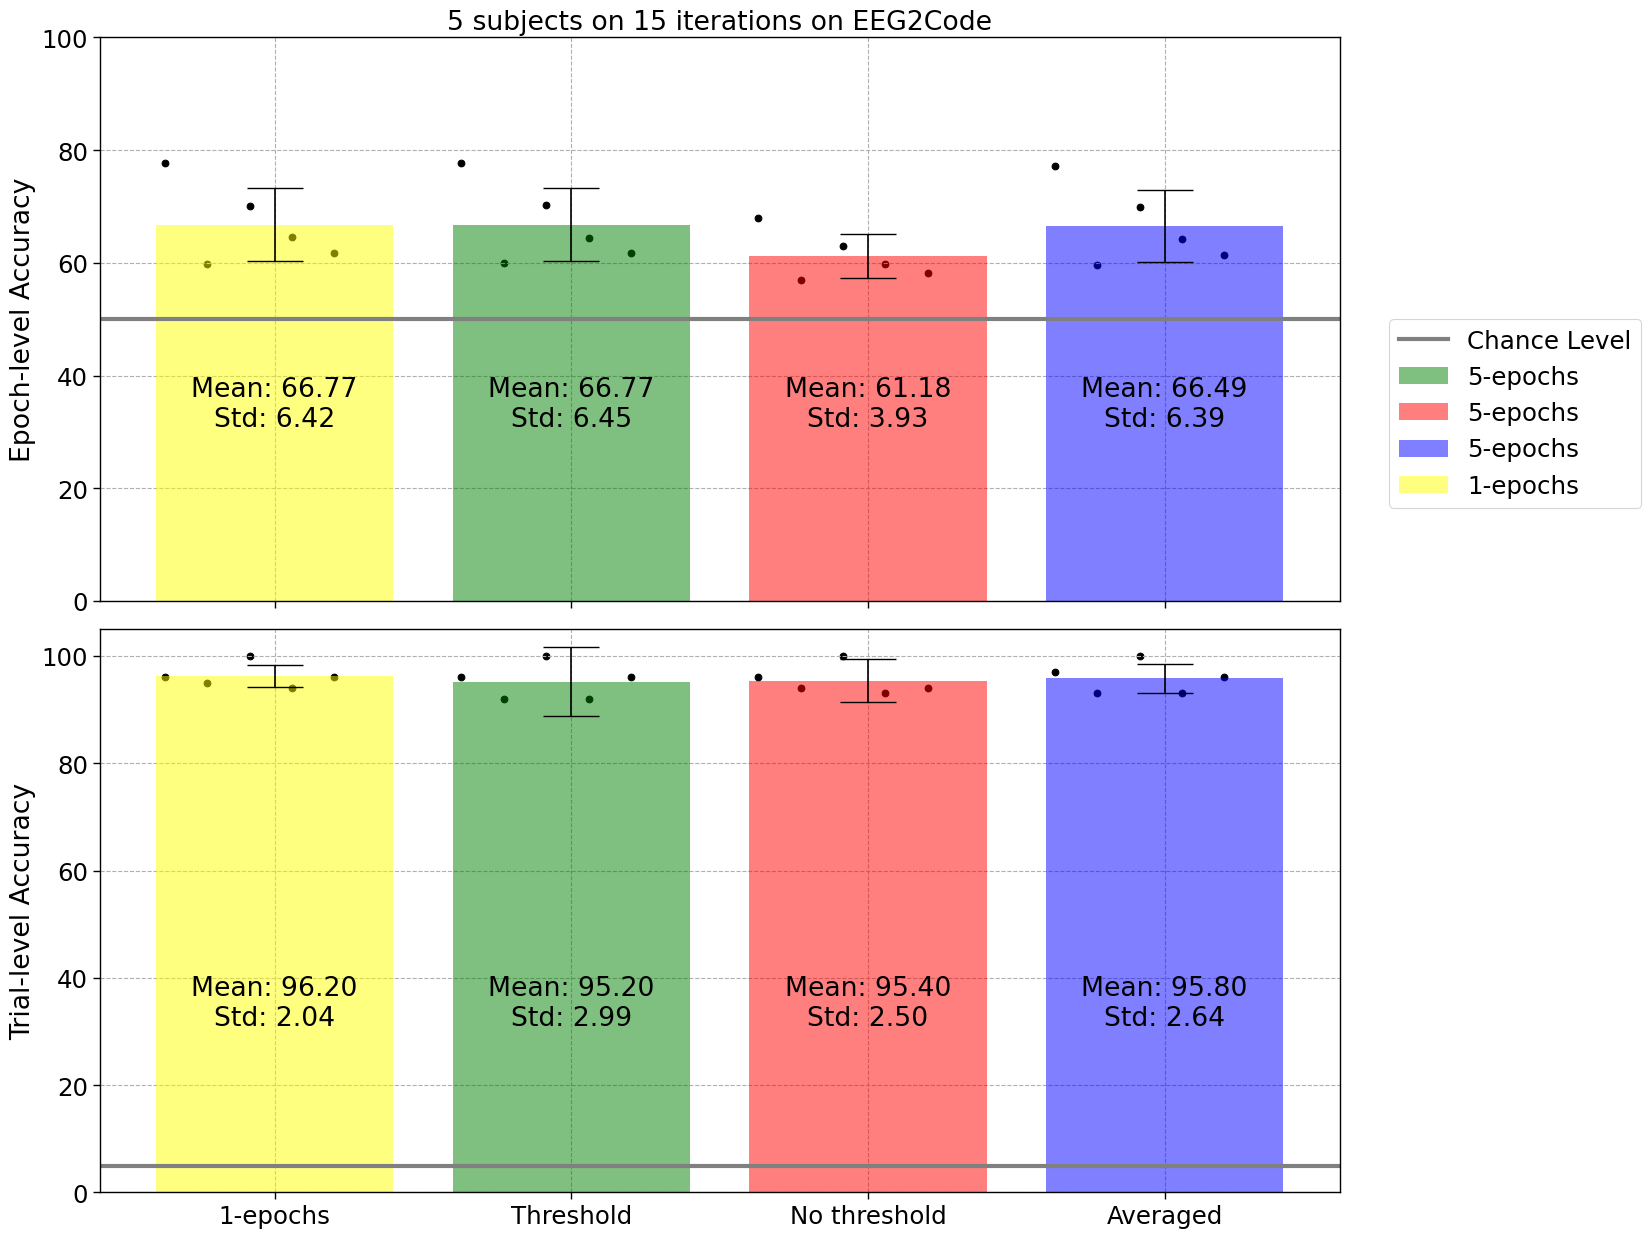

In [24]:
import seaborn as sns
sns.set_context("paper", font_scale=2)
print(EEG2Code_acc_epoch)
print(EEG2Code_acc_trial)
bars = np.arange(4)
bar_width = 0.8
print("EEG2Code_acc_epoch_threshold",np.mean(EEG2Code_acc_epoch_threshold),accuracy_epoch_eeg2code_threshold)
print("EEG2Code_acc_epoch_nothreshold",np.mean(EEG2Code_acc_epoch_nothreshold),accuracy_epoch_eeg2code_nothreshold)
print("EEG2Code_acc_epoch_avg",np.mean(EEG2Code_acc_epoch_avg),accuracy_epoch_eeg2code_avg)
print("EEG2Code_acc_epoch",np.mean(EEG2Code_acc_epoch),accuracy_epoch_eeg2code)
print("EEG2Code_acc_trial_threshold",np.mean(EEG2Code_acc_trial_threshold),accuracy_trial_eeg2code_threshold)
print("EEG2Code_acc_trial_nothreshold",np.mean(EEG2Code_acc_trial_nothreshold),accuracy_trial_eeg2code_nothreshold)
print("EEG2Code_acc_trial_avg",np.mean(EEG2Code_acc_trial_avg),accuracy_trial_eeg2code_avg)
print("EEG2Code_acc_trial",np.mean(EEG2Code_acc_trial),accuracy_trial_eeg2code)

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16, 15))
plt.subplots_adjust(wspace=0, hspace=0.05)

bar1 = ax1.bar(bars[1], np.mean(EEG2Code_acc_epoch_threshold), bar_width, label='5-epochs', yerr=np.std(EEG2Code_acc_epoch_threshold), capsize=20, zorder=2, alpha=0.5, color='green')
bar2 = ax1.bar(bars[2], np.mean(EEG2Code_acc_epoch_nothreshold), bar_width, label='5-epochs', yerr=np.std(EEG2Code_acc_epoch_nothreshold), capsize=20, zorder=2, alpha=0.5, color='red')
bar3 = ax1.bar(bars[3], np.mean(EEG2Code_acc_epoch_avg), bar_width, label='5-epochs', yerr=np.std(EEG2Code_acc_epoch_avg), capsize=20, zorder=2, alpha=0.5, color='blue')
bar4 = ax1.bar(bars[0], np.mean(EEG2Code_acc_epoch), bar_width, label='1-epochs', yerr=np.std(EEG2Code_acc_epoch), capsize=20, zorder=2, alpha=0.5, color='yellow')

for i, acc_epoch in enumerate([EEG2Code_acc_epoch, EEG2Code_acc_epoch_threshold,EEG2Code_acc_epoch_nothreshold, EEG2Code_acc_epoch_avg]):
    x_pos = bars[i]
    for j, acc in enumerate(acc_epoch):
        ax1.scatter(x_pos -0.37 + j/7, acc, color='black')
        
ax1.text(bars[1], 30, f'Mean: {np.mean(EEG2Code_acc_epoch_threshold):.2f}\nStd: {np.std(EEG2Code_acc_epoch_threshold):.2f}', ha='center', va='bottom')
ax1.text(bars[2], 30, f'Mean: {np.mean(EEG2Code_acc_epoch_nothreshold):.2f}\nStd: {np.std(EEG2Code_acc_epoch_nothreshold):.2f}', ha='center', va='bottom')
ax1.text(bars[3], 30, f'Mean: {np.mean(EEG2Code_acc_epoch_avg):.2f}\nStd: {np.std(EEG2Code_acc_epoch_avg):.2f}', ha='center', va='bottom')
ax1.text(bars[0], 30, f'Mean: {np.mean(EEG2Code_acc_epoch):.2f}\nStd: {np.std(EEG2Code_acc_epoch):.2f}', ha='center', va='bottom')

ax1.axhline(y=50, color='grey', linestyle='-', linewidth=3, label='Chance Level')
ax1.set_title(f'5 subjects on {epochs} iterations on EEG2Code')
ax1.set_xticklabels([])
ax1.set_xticks(bars)
ax1.set_ylabel('Epoch-level Accuracy')
ax1.legend(bbox_to_anchor=(1.04, 0.5), loc='upper left', borderaxespad=0)
ax1.set_ylim(0,100)
ax1.grid(linestyle='dashed')

bar5 = ax2.bar(bars[1], np.mean(EEG2Code_acc_trial_threshold), bar_width, label='5-epochs', yerr=np.std(EEG2Code_acc_epoch_threshold), capsize=20, zorder=2, alpha=0.5, color='green')
bar6 = ax2.bar(bars[2], np.mean(EEG2Code_acc_trial_nothreshold), bar_width, label='5-epochs', yerr=np.std(EEG2Code_acc_epoch_nothreshold), capsize=20, zorder=2, alpha=0.5, color='red')
bar7 = ax2.bar(bars[3], np.mean(EEG2Code_acc_trial_avg), bar_width, label='5-epochs', yerr=np.std(EEG2Code_acc_trial_avg), capsize=20, zorder=2, alpha=0.5, color='blue')
bar7 = ax2.bar(bars[0], np.mean(EEG2Code_acc_trial), bar_width, label='1-epochs', yerr=np.std(EEG2Code_acc_trial), capsize=20, zorder=2, alpha=0.5, color='yellow')

for i, acc_epoch in enumerate([EEG2Code_acc_trial, EEG2Code_acc_trial_threshold,EEG2Code_acc_trial_nothreshold, EEG2Code_acc_trial_avg]):
    x_pos = bars[i]
    for j, acc in enumerate(acc_epoch):
        ax2.scatter(x_pos -0.37 + j/7, acc, color='black')
print(EEG2Code_acc_trial)
ax2.text(bars[1], 30, f'Mean: {np.mean(EEG2Code_acc_trial_threshold):.2f}\nStd: {np.std(EEG2Code_acc_trial_threshold):.2f}', ha='center', va='bottom')
ax2.text(bars[2], 30, f'Mean: {np.mean(EEG2Code_acc_trial_nothreshold):.2f}\nStd: {np.std(EEG2Code_acc_trial_nothreshold):.2f}', ha='center', va='bottom')
ax2.text(bars[3], 30, f'Mean: {np.mean(EEG2Code_acc_trial_avg):.2f}\nStd: {np.std(EEG2Code_acc_trial_avg):.2f}', ha='center', va='bottom')
ax2.text(bars[0], 30, f'Mean: {np.mean(EEG2Code_acc_trial):.2f}\nStd: {np.std(EEG2Code_acc_trial):.2f}', ha='center', va='bottom')

ax2.axhline(y=5, color='grey', linestyle='-', linewidth=3, label='Chance Level')
ax2.set_xticks(bars)
ax2.set_xticklabels(['1-epochs','Threshold', 'No threshold', 'Averaged',])
ax2.set_ylabel('Trial-level Accuracy')
ax2.set_ylim(0,105)
ax2.grid(linestyle='dashed')

fig.savefig('5-epoching comparison.svg', format='svg',transparent=True)
fig.savefig('5-epoching comparison.png', bbox_inches='tight')
plt.show()

In [21]:
from scipy.stats import wilcoxon

w, p_one_threshold = wilcoxon(np.mean(EEG2Code_acc_epoch),np.mean(EEG2Code_acc_epoch_threshold) , alternative = 'less')
w, p_one_threshold_trial =  wilcoxon(np.mean(EEG2Code_acc_trial),np.mean(EEG2Code_acc_trial_threshold) , alternative = 'less')
w, p_one_nothreshold =  wilcoxon(np.mean(EEG2Code_acc_epoch), np.mean(EEG2Code_acc_epoch_nothreshold), alternative = 'less')
w, p_one_nothreshold_trial =  wilcoxon(np.mean(EEG2Code_acc_trial), np.mean(EEG2Code_acc_trial_nothreshold), alternative = 'less')
w, p_one_avg =  wilcoxon(np.mean(EEG2Code_acc_epoch),np.mean(EEG2Code_acc_epoch_avg) , alternative = 'less')
w, p_one_avg_trial =  wilcoxon(np.mean(EEG2Code_acc_trial),np.mean(EEG2Code_acc_trial_avg) , alternative = 'less')
print("p_one_threshold: ",p_one_threshold)
print("p_one_threshold_trial: ",p_one_threshold_trial)
print("p_one_nothreshold: ",p_one_nothreshold)
print("p_one_nothreshold_trial: ",p_one_nothreshold_trial)
print("p_one_avg: ",p_one_avg)
print("p_one_avg_trial: ",p_one_avg_trial)

w, p_threshold_one = wilcoxon(np.mean(EEG2Code_acc_epoch_threshold), np.mean(EEG2Code_acc_epoch), alternative = 'less')
w, p_threshold_one_trial =  wilcoxon(np.mean(EEG2Code_acc_trial_threshold),np.mean(EEG2Code_acc_trial) , alternative = 'less')
w, p_threshold_nothreshold =  wilcoxon(np.mean(EEG2Code_acc_epoch_threshold), np.mean(EEG2Code_acc_epoch_nothreshold), alternative = 'less')
w, p_threshold_nothreshold_trial =  wilcoxon(np.mean(EEG2Code_acc_trial_threshold),np.mean(EEG2Code_acc_trial_nothreshold) , alternative = 'less')
w, p_threshold_avg =  wilcoxon(np.mean(EEG2Code_acc_epoch_threshold),np.mean(EEG2Code_acc_epoch_avg) , alternative = 'less')
w, p_threshold_avg_trial =  wilcoxon(np.mean(EEG2Code_acc_trial_threshold), np.mean(EEG2Code_acc_trial_avg), alternative = 'less')
print("p_threshold_one: ",p_threshold_one)
print("p_threshold_one_trial: ",p_threshold_one_trial)
print("p_threshold_nothreshold: ",p_threshold_nothreshold)
print("p_threshold_nothreshold_trial: ",p_threshold_nothreshold_trial)
print("p_threshold_avg: ",p_threshold_avg)
print("p_threshold_avg_trial: ",p_threshold_avg_trial)
w, p_nothreshold_one = wilcoxon(np.mean(EEG2Code_acc_epoch_nothreshold), np.mean(EEG2Code_acc_epoch), alternative = 'less')
w, p_nothreshold_one_trial =  wilcoxon(np.mean(EEG2Code_acc_trial_nothreshold), np.mean(EEG2Code_acc_trial), alternative = 'less')
w, p_nothreshold_threshold =  wilcoxon(np.mean(EEG2Code_acc_epoch_nothreshold), np.mean(EEG2Code_acc_epoch_threshold), alternative = 'less')
w, p_nothreshold_threshold_trial =  wilcoxon(np.mean(EEG2Code_acc_trial_nothreshold),np.mean(EEG2Code_acc_trial_threshold) , alternative = 'less')
w, p_nothreshold_avg =  wilcoxon(np.mean(EEG2Code_acc_epoch_nothreshold),np.mean(EEG2Code_acc_epoch_avg) , alternative = 'less')
w, p_nothreshold_avg_trial =  wilcoxon(np.mean(EEG2Code_acc_trial_nothreshold),np.mean(EEG2Code_acc_trial_avg) , alternative = 'less')
print("p_nothreshold_one: ",p_nothreshold_one)
print("p_nothreshold_one_trial: ",p_nothreshold_one_trial)
print("p_nothreshold_threshold: ",p_nothreshold_threshold)
print("p_nothreshold_threshold_trial: ",p_nothreshold_threshold_trial)
print("p_nothreshold_avg: ",p_nothreshold_avg)
print("p_nothreshold_avg_trial: ",p_nothreshold_avg_trial)
w, p_avg_one = wilcoxon(np.mean(EEG2Code_acc_epoch_avg), np.mean(EEG2Code_acc_epoch), alternative = 'less')
w, p_avg_oned_trial =  wilcoxon(np.mean(EEG2Code_acc_trial_avg),np.mean(EEG2Code_acc_trial) , alternative = 'less')
w, p_avg_threshold =  wilcoxon(np.mean(EEG2Code_acc_epoch_avg),np.mean(EEG2Code_acc_epoch_threshold) , alternative = 'less')
w, p_avg_threshold_trial =  wilcoxon(np.mean(EEG2Code_acc_trial_avg),np.mean(EEG2Code_acc_trial_threshold) , alternative = 'less')
w, p_avg_nothreshold =  wilcoxon(np.mean(EEG2Code_acc_epoch_avg),np.mean(EEG2Code_acc_epoch_nothreshold) , alternative = 'less')
w, p_avg_nothreshold_trial =  wilcoxon(np.mean(EEG2Code_acc_trial_avg), np.mean(EEG2Code_acc_trial_nothreshold), alternative = 'less')
print("p_avg_one: ",p_avg_one)
print("p_avg_oned_trial: ",p_avg_oned_trial)
print("p_avg_threshold: ",p_avg_threshold)
print("p_avg_threshold_trial: ",p_avg_threshold_trial)
print("p_avg_nothreshold: ",p_avg_nothreshold)
print("p_avg_nothreshold_trial: ",p_avg_nothreshold_trial)

p = [p_one_threshold,p_one_nothreshold,p_one_avg,p_threshold_one,p_threshold_nothreshold,p_threshold_avg,
     p_nothreshold_one,p_nothreshold_threshold,p_nothreshold_avg,p_avg_one,p_avg_threshold,p_avg_nothreshold,
     p_one_threshold_trial,p_one_nothreshold_trial,p_one_avg_trial,p_threshold_one_trial,p_threshold_nothreshold_trial,p_threshold_avg_trial,
     p_nothreshold_one_trial,p_nothreshold_threshold_trial,p_nothreshold_avg_trial,p_avg_oned_trial,p_avg_threshold_trial,p_avg_nothreshold_trial
    ]
from statsmodels.sandbox.stats.multicomp import multipletests
p_adjusted = multipletests(p, method='bonferroni')
print("bonferroni ",p_adjusted)

p_one_threshold:  1.0
p_one_threshold_trial:  1.0
p_one_nothreshold:  1.0
p_one_nothreshold_trial:  1.0
p_one_avg:  1.0
p_one_avg_trial:  1.0
p_threshold_one:  0.5
p_threshold_one_trial:  0.5
p_threshold_nothreshold:  1.0
p_threshold_nothreshold_trial:  0.5
p_threshold_avg:  1.0
p_threshold_avg_trial:  0.5
p_nothreshold_one:  0.5
p_nothreshold_one_trial:  0.5
p_nothreshold_threshold:  0.5
p_nothreshold_threshold_trial:  1.0
p_nothreshold_avg:  0.5
p_nothreshold_avg_trial:  0.5
p_avg_one:  0.5
p_avg_oned_trial:  0.5
p_avg_threshold:  0.5
p_avg_threshold_trial:  1.0
p_avg_nothreshold:  1.0
p_avg_nothreshold_trial:  1.0
bonferroni  (array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.]), 0.002134938369701578, 0.0020833333333333333)


## Save data

In [ ]:
"""
Save training history and epoch level classification
"""
# Save accuracies history
with open(os.path.join(path, 'historymajorityvote', 'EEG2Code_epoch_accuracies_threshold.txt'), 'w') as f:
    for acc in EEG2Code_acc_epoch_threshold:
        f.write('%s\n' % acc)
with open(os.path.join(path, 'historymajorityvote', 'EEG2Code_epoch_accuracies_nothreshold.txt'), 'w') as f:
    for acc in EEG2Code_acc_epoch_nothreshold:
        f.write('%s\n' % acc)
with open(os.path.join(path, 'historymajorityvote', 'EEG2Code_epoch_accuracies_avg.txt'), 'w') as f:
    for acc in EEG2Code_acc_epoch_avg:
        f.write('%s\n' % acc)
        
with open(os.path.join(path, 'historymajorityvote', 'EEG2Code_trial_accuracies_threshold.txt'), 'w') as f:
    for acc in EEG2Code_acc_trial_threshold:
        f.write('%s\n' % acc)
with open(os.path.join(path, 'historymajorityvote', 'EEG2Code_trial_accuracies_nothreshold.txt'), 'w') as f:
    for acc in EEG2Code_acc_trial_nothreshold:
        f.write('%s\n' % acc)
with open(os.path.join(path, 'historymajorityvote', 'EEG2Code_trial_accuracies_avg.txt'), 'w') as f:
    for acc in EEG2Code_acc_trial_avg:
        f.write('%s\n' % acc)

with open(os.path.join(path, 'historymajorityvote', 'EEG2Code_epoch_accuracies.txt'), 'w') as f:
    for acc in EEG2Code_acc_epoch:
        f.write('%s\n' % acc)
with open(os.path.join(path, 'historymajorityvote', 'EEG2Code_trial_accuracies.txt'), 'w') as f:
    for acc in EEG2Code_acc_trial:
        f.write('%s\n' % acc)
        
# Save epoch predictions of all fold of all subjects
if not os.path.exists(os.path.join(path, 'historymajorityvote')):
    os.makedirs(os.path.join(path, 'historymajorityvote'))
np.save(os.path.join(path, 'historymajorityvote', 'epoch_predictions_saveall_eeg2code_threshold.npy'), epoch_predictions_saveall_eeg2code_threshold)
np.save(os.path.join(path, 'historymajorityvote', 'epoch_predictions_saveall_eeg2code_nothreshold.npy'), epoch_predictions_saveall_eeg2code_nothreshold)
np.save(os.path.join(path, 'historymajorityvote', 'epoch_predictions_saveall_eeg2code_avg.npy'), epoch_predictions_saveall_eeg2code_avg)
np.save(os.path.join(path, 'historymajorityvote', 'epoch_predictions_saveall_eeg2code.npy'), epoch_predictions_saveall_eeg2code)